In [72]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import RobustScaler
import matplotlib.pyplot as plt
import seaborn as sns
import skfuzzy as fuzz
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
data = pd.read_csv('Hasil_Gabungan.csv')

In [73]:
featuress = [
    'Residential_2021', 'Industrial_2021', 'Business_2021', 'Social_2021', 'Gov_Office_2021', 
    'Pub_Street_2021', 'Total_2021', 'Residential_2022', 'Industrial_2022', 'Business_2022', 
    'Social_2022', 'Gov_Office_2022', 'Pub_Street_2022', 'Total_2022', 'Residential', 
    'Industrial', 'Business', 'Social', 'Gov_Office', 'Pub_Street', 'Total', 
    'JP_2021', 'JP_2022', 'JP_2023', 'KP_2021', 'KP_2022', 'KP_2023'
]

np.random.seed(42)
dataS = data[featuress]
dataS['Provinsi'] = data['Province']

scaler = RobustScaler()
dataS_scaled = scaler.fit_transform(dataS[featuress])

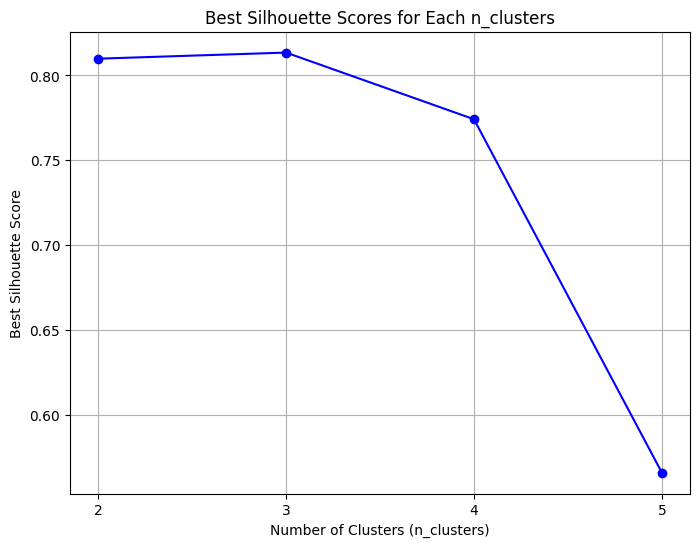

Best Parameters: m=1.5, error=0.0001, maxiter=100, n_clusters=3
Best Silhouette Score: 0.8134610115525492


In [74]:
import matplotlib.pyplot as plt

def optimize_fcm(X, m_values, error_values, maxiter_values, n):
    best_sil_score = -1
    best_params = None
    best_model = None
    sil_scoresbest = {n_clusters: -1 for n_clusters in n}  

    for m in m_values:
        for error in error_values:
            for maxiter in maxiter_values:
                for n_clusters in n:
                    cntr, u, _, _, _, _, _ = fuzz.cmeans(X.T, c=n_clusters, m=m, error=error, maxiter=maxiter, init=None)
                    labels = np.argmax(u, axis=0)

                    sil_score = silhouette_score(X, labels)
                    if sil_score > sil_scoresbest[n_clusters]:
                        sil_scoresbest[n_clusters] = sil_score

                        if sil_score > best_sil_score:
                            best_sil_score = sil_score
                            best_params = (m, error, maxiter, n_clusters)
                            best_model = (cntr, u)

    n_clusters_values = list(sil_scoresbest.keys())
    best_sil_scores = list(sil_scoresbest.values())

    plt.figure(figsize=(8, 6))
    plt.plot(n_clusters_values, best_sil_scores, marker='o', linestyle='-', color='b')
    plt.title('Best Silhouette Scores for Each n_clusters')
    plt.xlabel('Number of Clusters (n_clusters)')
    plt.ylabel('Best Silhouette Score')
    plt.xticks(n) 
    plt.grid(True)
    plt.show()

    return best_params, best_sil_score, best_model

m = [1.5, 2.0, 2.5]  
error = [0.0001, 0.0005]  
maxiter = [100, 200]  
n = range(2, 6)  
best_params, best_sil_score, best_model = optimize_fcm(dataS_scaled, m, error, maxiter, n)

print(f"Best Parameters: m={best_params[0]}, error={best_params[1]}, maxiter={best_params[2]}, n_clusters={best_params[3]}")
print(f"Best Silhouette Score: {best_sil_score}")


In [75]:
data_ = data[featuress]

scaler = RobustScaler()
scaled_features = scaler.fit_transform(data_)

n_clusters =3

cntr, u, _, _, _, _, _ = fuzz.cmeans(scaled_features.T, c=n_clusters, m=1.5, error=0.001, maxiter=100, init=None)

labels = np.argmax(u, axis=0)

cluster_provinces = {}
provinces = data['Province'].tolist()  

for cluster_idx in range(n_clusters):
    cluster_provinces[cluster_idx] = [provinces[i] for i in range(len(labels)) if labels[i] == cluster_idx]

for cluster_idx, provinces_in_cluster in cluster_provinces.items():
    print(f"Cluster {cluster_idx + 1}: {', '.join(provinces_in_cluster)}")

sil_score = silhouette_score(scaled_features, labels)
print(f"Silhouette Score: {sil_score}")

Cluster 1: DKI Jakarta
Cluster 2: Aceh, Sumatera Utara, Sumatera Barat, Riau, Kep. Riau, Sumatera Selatan, Jambi, Bengkulu, Kep. Bangka Belitung, Lampung, Kalimantan Barat, Kalimantan Selatan, Kalimantan Tengah, Sulawesi Utara, Gorontalo, Sulawesi Tengah, Sulawesi Selatan, Sulawesi Tenggara, Sulawesi Barat, Maluku, Maluku Utara, Papua, Papua Barat, Bali, Nusa Tenggara Barat, Nusa Tenggara Timur, DI Yogyakarta, Kalimantan Timur, Kalimantan Utara
Cluster 3: Jawa Timur, Jawa Tengah, Jawa Barat, Banten
Silhouette Score: 0.8134610115525492


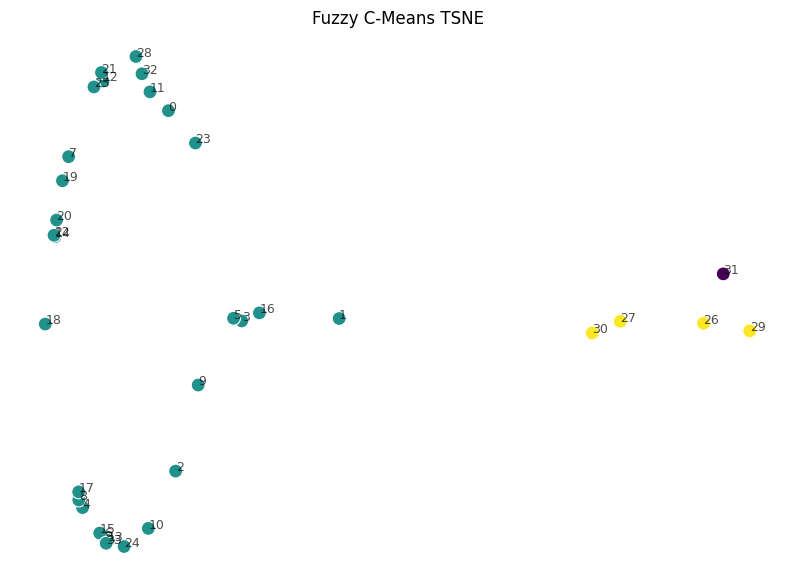

In [76]:
def plot_tsne_with_clusters(X, labels, provinsi_names):
    tsne = TSNE(n_components=2, random_state=42)
    X_tsne = tsne.fit_transform(X) 

    df_tsne = pd.DataFrame(data=X_tsne, columns=['tSNE1', 'tSNE2'])
    df_tsne['Cluster'] = labels
    df_tsne['Provinsi'] = provinsi_names 

    plt.figure(figsize=(10, 7))
    sns.scatterplot(data=df_tsne, x='tSNE1', y='tSNE2', hue='Cluster', palette='viridis', s=100, legend=None)

    for i in range(len(provinsi_names)):
        plt.text(df_tsne.loc[i, 'tSNE1'], df_tsne.loc[i, 'tSNE2'], str(i), fontsize=9, alpha=0.7)
    
    plt.title('Fuzzy C-Means TSNE')
    plt.axis("off")
    plt.show()

plot_tsne_with_clusters(scaled_features, labels, data['Province'].tolist())

In [77]:
import umap

def plot_umap_fuzzy_cmeans(X, labels, provinsi_names, title='Fuzzy C-Means UMAP'):
    reducer = umap.UMAP(random_state=42)
    X_umap = reducer.fit_transform(X)

    df_umap = pd.DataFrame(X_umap, columns=['UMAP1', 'UMAP2'])
    df_umap['Cluster'] = labels
    df_umap['Provinsi'] = provinsi_names

    plt.figure(figsize=(10, 7))
    sns.scatterplot(data=df_umap, x='UMAP1', y='UMAP2', hue='Cluster', palette='viridis', s=100, legend=None)

    for i in range(len(df_umap)):
        plt.text(df_umap.loc[i, 'UMAP1'], df_umap.loc[i, 'UMAP2'], str(i), fontsize=9, alpha=0.7)

    plt.title(title)
    plt.axis('off')
    plt.show()


c:\Users\Jeff\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Jeff\AppData\Local\Programs\Python\Python313\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


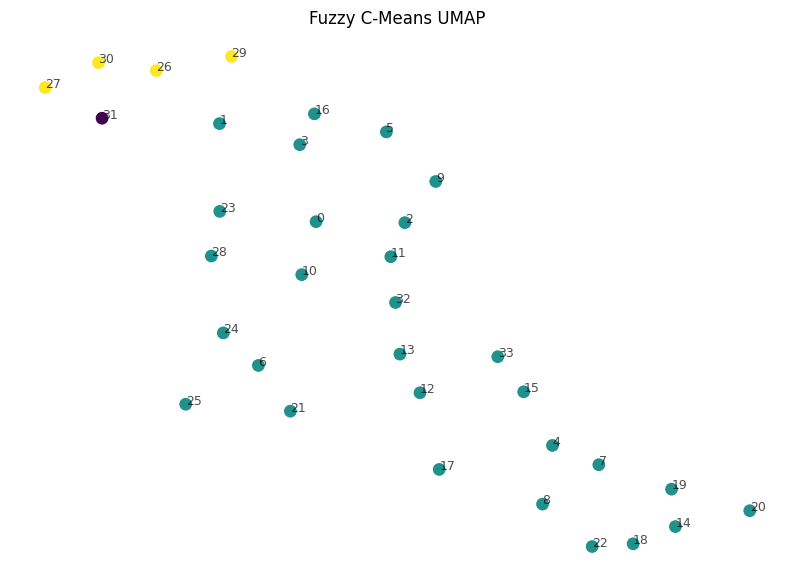

In [78]:
plot_umap_fuzzy_cmeans(scaled_features, labels, data['Province'].tolist())